# Домашнее задание № 9

### Задание 1 (10 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs_torch.ipynb

На датасете lenta_sample.ru  дообучите две модели - modernbert-base (из семинара) и rumodernbert-base (https://huggingface.co/deepvk/RuModernBERT-base). Оцените разницу в качестве сравнив поклассовые метрики (classification_report)

Для обоих моделей качество должно быть >0.10 по f-мере (прогоните несколько экспериментов если у вас получаются нули, изменяя параметры).
Также для обоих моделей попробуйте дообучать модель и целиком и дообучать только последний слой.
Для RuModernBERT дополнительно сравните модель, которая использует первый вектор (cls токен, как в семинаре), так и усредненный вектор по всем hidden_state, который выдает bert.




я снова копирую из ячейки в ячейку вместо написания функций(( простите

In [ ]:
# !pip install datasets --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from datasets import load_dataset

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

In [ ]:
MAX_LEN = 512

# Данные

In [ ]:
data = pd.read_csv("lenta_sample.csv")
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29
...,...,...,...,...,...,...
602,https://lenta.ru/news/2014/09/14/pattern/,1914. Выкройки для раненых,"В дополнение к выкройкам белья для раненых, ра...",Библиотека,Первая мировая,2014/09/14
603,https://lenta.ru/news/2014/12/23/christmas/,1914. Немецкие и британские солдаты отметили п...,24 декабря в Бельгии в районе Ипра произошло н...,Библиотека,Первая мировая,2014/12/23
604,https://lenta.ru/news/2014/10/21/dobrovolec/,1914. Польский доброволец-герой,В числе поступивших в нашу армию добровольцев ...,Библиотека,Первая мировая,2014/10/21
605,https://lenta.ru/news/2014/09/18/postoffice/,1914. Письма в действующую армию на деревню де...,За последнее время на имя начальника штаба Вер...,Библиотека,Первая мировая,2014/09/18


In [ ]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [ ]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

# Модели и обучение

In [ ]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)

        return outputs

In [ ]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))



        loss.backward()
        optimizer.step()
        preds = predictions.detach().to(device).numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to(device).numpy().argmax(1).tolist()
            y_true = ys.tolist()


            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)

In [ ]:
def predict(model, iterator):

    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

## modernbert

In [ ]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

#без замораживания

In [ ]:
model = AutoModel.from_pretrained(model_id)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(30)):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/30 [00:00<?, ?it/s]

0


  3%|▎         | 1/30 [01:21<39:24, 81.52s/it]

Eval -  0.06458333333333333
1


  7%|▋         | 2/30 [02:42<37:47, 80.97s/it]

Eval -  0.09375
2


 10%|█         | 3/30 [04:02<36:20, 80.75s/it]

Eval -  0.03333333333333333
3


 13%|█▎        | 4/30 [05:23<34:57, 80.67s/it]

Eval -  0.06458333333333333
4


 17%|█▋        | 5/30 [06:43<33:35, 80.60s/it]

Eval -  0.0
5


 20%|██        | 6/30 [08:04<32:13, 80.56s/it]

Eval -  0.03125
6


 23%|██▎       | 7/30 [09:24<30:53, 80.61s/it]

Eval -  0.03333333333333333
7


 27%|██▋       | 8/30 [10:45<29:33, 80.62s/it]

Eval -  0.13125
8


 30%|███       | 9/30 [12:06<28:12, 80.61s/it]

Eval -  0.19166666666666665
9


 33%|███▎      | 10/30 [13:26<26:53, 80.67s/it]

Eval -  0.29166666666666663
10


 37%|███▋      | 11/30 [14:47<25:33, 80.71s/it]

Eval -  0.19375
11


 40%|████      | 12/30 [16:08<24:13, 80.75s/it]

Eval -  0.25416666666666665
12


 43%|████▎     | 13/30 [17:29<22:52, 80.75s/it]

Eval -  0.22083333333333333
13


 47%|████▋     | 14/30 [18:50<21:32, 80.79s/it]

Eval -  0.22708333333333333
14


 50%|█████     | 15/30 [20:10<20:11, 80.79s/it]

Eval -  0.29166666666666663
15


 53%|█████▎    | 16/30 [21:31<18:51, 80.81s/it]

Eval -  0.2583333333333333
16


 57%|█████▋    | 17/30 [22:52<17:30, 80.83s/it]

Eval -  0.19791666666666666
17


 60%|██████    | 18/30 [24:13<16:10, 80.87s/it]

Eval -  0.23125
18


 63%|██████▎   | 19/30 [25:34<14:49, 80.85s/it]

Eval -  0.22291666666666665
19


 67%|██████▋   | 20/30 [26:55<13:28, 80.85s/it]

Eval -  0.225
20


 70%|███████   | 21/30 [28:16<12:07, 80.87s/it]

Eval -  0.22291666666666665
21


 73%|███████▎  | 22/30 [29:37<10:47, 80.88s/it]

Eval -  0.29166666666666663
22


 77%|███████▋  | 23/30 [30:58<09:26, 80.94s/it]

Eval -  0.19166666666666665
23


 80%|████████  | 24/30 [32:19<08:05, 80.95s/it]

Eval -  0.16041666666666665
24


 83%|████████▎ | 25/30 [33:40<06:44, 80.98s/it]

Eval -  0.1625
25


 87%|████████▋ | 26/30 [35:01<05:23, 80.96s/it]

Eval -  0.19166666666666665
26


 90%|█████████ | 27/30 [36:22<04:02, 80.99s/it]

Eval -  0.13125
27


 93%|█████████▎| 28/30 [37:43<02:41, 80.96s/it]

Eval -  0.16458333333333333
28


 97%|█████████▋| 29/30 [39:03<01:20, 80.95s/it]

Eval -  0.25625
29


100%|██████████| 30/30 [40:24<00:00, 80.83s/it]

Eval -  0.19375


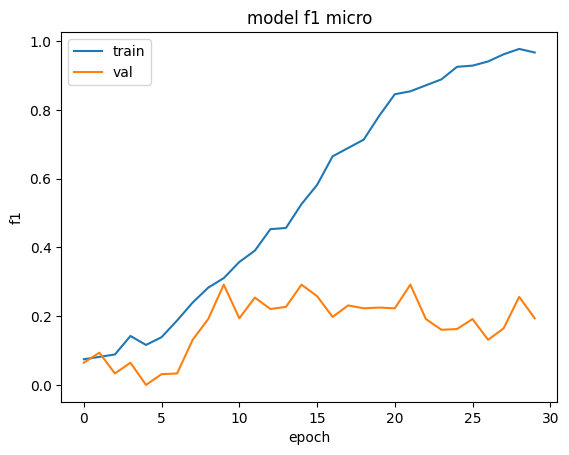

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.25      0.50      0.33         2
           4       0.33      0.20      0.25         5
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       1.00      0.50      0.67         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          15       0.50      0.33      0.40         3
          16       0.00      0.00      0.00         3

    accuracy                           0.19        31
   macro avg       0.21      0.15      0.16        31
weighted avg       0.28   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

По большинству классов нулевые метрики, общий f1-score по валидационному датасетуоколо 0.2, хотя на трейне f1 близок к одному, переобучение?


#с заморозкой

In [ ]:
model = AutoModel.from_pretrained(model_id)
for param in model.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(40)):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/40 [00:00<?, ?it/s]

0


  2%|▎         | 1/40 [00:25<16:25, 25.27s/it]

Eval -  0.12903225806451613
1


  5%|▌         | 2/40 [00:50<16:04, 25.39s/it]

Eval -  0.16129032258064516
2


  8%|▊         | 3/40 [01:15<15:35, 25.29s/it]

Eval -  0.16129032258064516
3


 10%|█         | 4/40 [01:40<15:07, 25.20s/it]

Eval -  0.0967741935483871
4


 12%|█▎        | 5/40 [02:06<14:40, 25.16s/it]

Eval -  0.22580645161290322
5


 15%|█▌        | 6/40 [02:31<14:15, 25.15s/it]

Eval -  0.1935483870967742
6


 18%|█▊        | 7/40 [02:56<13:50, 25.17s/it]

Eval -  0.1935483870967742
7


 20%|██        | 8/40 [03:21<13:25, 25.17s/it]

Eval -  0.1935483870967742
8


 22%|██▎       | 9/40 [03:46<13:01, 25.20s/it]

Eval -  0.22580645161290322
9


 25%|██▌       | 10/40 [04:12<12:36, 25.23s/it]

Eval -  0.25806451612903225
10


 28%|██▊       | 11/40 [04:37<12:11, 25.21s/it]

Eval -  0.1935483870967742
11


 30%|███       | 12/40 [05:02<11:44, 25.17s/it]

Eval -  0.22580645161290322
12


 32%|███▎      | 13/40 [05:27<11:18, 25.14s/it]

Eval -  0.1935483870967742
13


 35%|███▌      | 14/40 [05:52<10:52, 25.11s/it]

Eval -  0.1935483870967742
14


 38%|███▊      | 15/40 [06:17<10:29, 25.16s/it]

Eval -  0.1935483870967742
15


 40%|████      | 16/40 [06:43<10:04, 25.20s/it]

Eval -  0.22580645161290322
16


 42%|████▎     | 17/40 [07:08<09:38, 25.15s/it]

Eval -  0.25806451612903225
17


 45%|████▌     | 18/40 [07:33<09:13, 25.14s/it]

Eval -  0.1935483870967742
18


 48%|████▊     | 19/40 [07:58<08:49, 25.20s/it]

Eval -  0.25806451612903225
19


 50%|█████     | 20/40 [08:23<08:23, 25.17s/it]

Eval -  0.25806451612903225
20


 52%|█████▎    | 21/40 [08:48<07:57, 25.13s/it]

Eval -  0.25806451612903225
21


 55%|█████▌    | 22/40 [09:13<07:31, 25.10s/it]

Eval -  0.22580645161290322
22


 57%|█████▊    | 23/40 [09:38<07:06, 25.09s/it]

Eval -  0.25806451612903225
23


 60%|██████    | 24/40 [10:03<06:41, 25.09s/it]

Eval -  0.25806451612903225
24


 62%|██████▎   | 25/40 [10:29<06:16, 25.11s/it]

Eval -  0.25806451612903225
25


 65%|██████▌   | 26/40 [10:54<05:52, 25.15s/it]

Eval -  0.22580645161290322
26


 68%|██████▊   | 27/40 [11:19<05:27, 25.20s/it]

Eval -  0.25806451612903225
27


 70%|███████   | 28/40 [11:44<05:02, 25.21s/it]

Eval -  0.2903225806451613
28


 72%|███████▎  | 29/40 [12:10<04:37, 25.21s/it]

Eval -  0.2903225806451613
29


 75%|███████▌  | 30/40 [12:35<04:11, 25.20s/it]

Eval -  0.22580645161290322
30


 78%|███████▊  | 31/40 [13:00<03:46, 25.22s/it]

Eval -  0.2903225806451613
31


 80%|████████  | 32/40 [13:25<03:21, 25.22s/it]

Eval -  0.25806451612903225
32


 82%|████████▎ | 33/40 [13:50<02:56, 25.16s/it]

Eval -  0.2903225806451613
33


 85%|████████▌ | 34/40 [14:15<02:30, 25.15s/it]

Eval -  0.3225806451612903
34


 88%|████████▊ | 35/40 [14:41<02:05, 25.16s/it]

Eval -  0.2903225806451613
35


 90%|█████████ | 36/40 [15:06<01:40, 25.16s/it]

Eval -  0.2903225806451613
36


 92%|█████████▎| 37/40 [15:31<01:15, 25.17s/it]

Eval -  0.3225806451612903
37


 95%|█████████▌| 38/40 [15:56<00:50, 25.20s/it]

Eval -  0.2903225806451613
38


 98%|█████████▊| 39/40 [16:21<00:25, 25.22s/it]

Eval -  0.3225806451612903
39


100%|██████████| 40/40 [16:47<00:00, 25.18s/it]

Eval -  0.2903225806451613


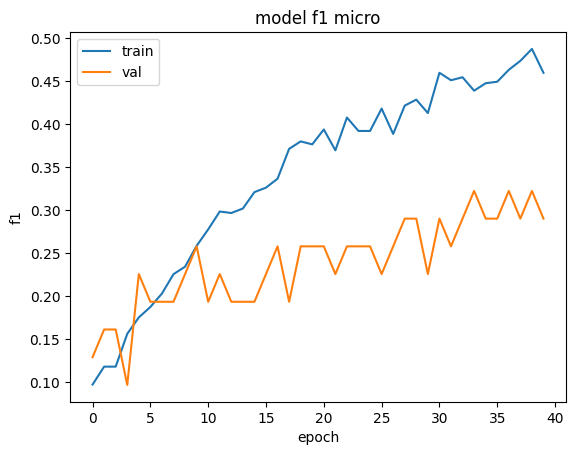

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         0
           3       0.25      0.50      0.33         2
           4       0.00      0.00      0.00         5
           5       0.50      1.00      0.67         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           9       0.50      0.50      0.50         2
          10       0.00      0.00      0.00         2
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.17      0.33      0.22         3

    accuracy                           0.29        31
   macro avg       0.19      0.27      0.22        31
weighted avg       0.21   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Метрики на val получше, на трейне модель, кажется, не переобучается

#rumodernbert

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

In [ ]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

## без заморозки

In [ ]:
model = AutoModel.from_pretrained(model_id)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(30)):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/30 [00:00<?, ?it/s]

0


  3%|▎         | 1/30 [01:22<39:43, 82.19s/it]

Eval -  0.22580645161290322
1


  7%|▋         | 2/30 [02:43<38:07, 81.69s/it]

Eval -  0.3548387096774194
2


 10%|█         | 3/30 [04:05<36:43, 81.62s/it]

Eval -  0.4838709677419355
3


 13%|█▎        | 4/30 [05:26<35:21, 81.60s/it]

Eval -  0.5483870967741935
4


 17%|█▋        | 5/30 [06:48<33:59, 81.57s/it]

Eval -  0.5806451612903226
5


 20%|██        | 6/30 [08:09<32:37, 81.56s/it]

Eval -  0.5806451612903226
6


 23%|██▎       | 7/30 [09:31<31:16, 81.60s/it]

Eval -  0.5483870967741935
7


 27%|██▋       | 8/30 [10:52<29:54, 81.55s/it]

Eval -  0.4838709677419355
8


 30%|███       | 9/30 [12:14<28:33, 81.58s/it]

Eval -  0.5483870967741935
9


 33%|███▎      | 10/30 [13:36<27:11, 81.60s/it]

Eval -  0.5161290322580645
10


 37%|███▋      | 11/30 [14:57<25:49, 81.57s/it]

Eval -  0.6129032258064516
11


 40%|████      | 12/30 [16:19<24:28, 81.56s/it]

Eval -  0.6451612903225806
12


 43%|████▎     | 13/30 [17:40<23:06, 81.54s/it]

Eval -  0.7419354838709677
13


 47%|████▋     | 14/30 [19:02<21:44, 81.53s/it]

Eval -  0.7096774193548387
14


 50%|█████     | 15/30 [20:23<20:22, 81.53s/it]

Eval -  0.6451612903225806
15


 53%|█████▎    | 16/30 [21:45<19:00, 81.49s/it]

Eval -  0.6451612903225806
16


 57%|█████▋    | 17/30 [23:06<17:38, 81.44s/it]

Eval -  0.6129032258064516
17


 60%|██████    | 18/30 [24:27<16:17, 81.42s/it]

Eval -  0.5806451612903226
18


 63%|██████▎   | 19/30 [25:49<14:55, 81.38s/it]

Eval -  0.5806451612903226
19


 67%|██████▋   | 20/30 [27:10<13:33, 81.37s/it]

Eval -  0.5806451612903226
20


 70%|███████   | 21/30 [28:31<12:12, 81.38s/it]

Eval -  0.5806451612903226
21


 73%|███████▎  | 22/30 [29:53<10:50, 81.36s/it]

Eval -  0.5806451612903226
22


 77%|███████▋  | 23/30 [31:14<09:29, 81.39s/it]

Eval -  0.6129032258064516
23


 80%|████████  | 24/30 [32:35<08:08, 81.36s/it]

Eval -  0.6451612903225806
24


 83%|████████▎ | 25/30 [33:57<06:46, 81.39s/it]

Eval -  0.6451612903225806
25


 87%|████████▋ | 26/30 [35:18<05:25, 81.41s/it]

Eval -  0.6451612903225806
26


 90%|█████████ | 27/30 [36:40<04:04, 81.41s/it]

Eval -  0.6451612903225806
27


 93%|█████████▎| 28/30 [38:01<02:42, 81.40s/it]

Eval -  0.6451612903225806
28


 97%|█████████▋| 29/30 [39:23<01:21, 81.43s/it]

Eval -  0.6451612903225806
29


100%|██████████| 30/30 [40:44<00:00, 81.48s/it]

Eval -  0.6451612903225806


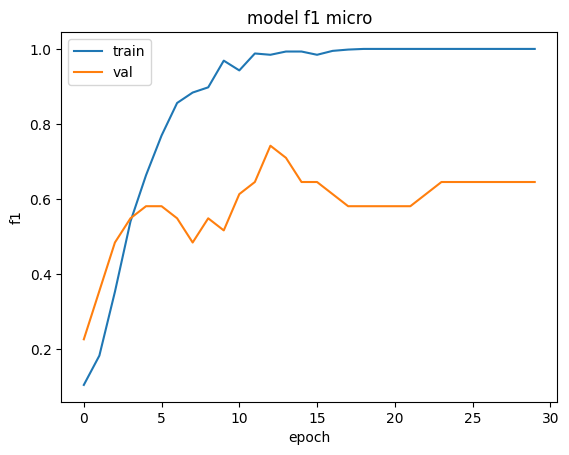

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         0
           3       0.67      1.00      0.80         2
           4       0.67      0.40      0.50         5
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.67      1.00      0.80         2
          12       0.00      0.00      0.00         1
          13       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         3
          16       0.67      0.67      0.67         3

    accuracy                           0.65        31
   macro avg       0.51      0.57      0.52        31
weighted avg       0.62   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Скоры ожидаемо лучше, чем у modernbert при обучении без заморозки, но кажется, что тут наблюдается похожая тенденция, модель хорошо учит трейн, но метрика для валидации стоит на месте. Не могу быстро догадаться, почему это происходит, может, спрошу на семинаре или погуглю сама позже (или переслушаю лекцию по берту)

## с заморозкой

In [ ]:
model = AutoModel.from_pretrained(model_id)
for param in model.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(40)):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/40 [00:00<?, ?it/s]

0


  2%|▎         | 1/40 [00:26<16:55, 26.04s/it]

Eval -  0.06458333333333333
1


  5%|▌         | 2/40 [00:52<16:37, 26.26s/it]

Eval -  0.03333333333333333
2


  8%|▊         | 3/40 [01:17<15:50, 25.69s/it]

Eval -  0.06458333333333333
3


 10%|█         | 4/40 [01:42<15:14, 25.40s/it]

Eval -  0.03125
4


 12%|█▎        | 5/40 [02:07<14:49, 25.41s/it]

Eval -  0.09791666666666667
5


 15%|█▌        | 6/40 [02:33<14:24, 25.42s/it]

Eval -  0.1
6


 18%|█▊        | 7/40 [02:58<13:56, 25.34s/it]

Eval -  0.09583333333333333
7


 20%|██        | 8/40 [03:23<13:30, 25.32s/it]

Eval -  0.03333333333333333
8


 22%|██▎       | 9/40 [03:49<13:05, 25.34s/it]

Eval -  0.03125
9


 25%|██▌       | 10/40 [04:14<12:40, 25.35s/it]

Eval -  0.09583333333333333
10


 28%|██▊       | 11/40 [04:39<12:14, 25.34s/it]

Eval -  0.12916666666666665
11


 30%|███       | 12/40 [05:05<11:50, 25.36s/it]

Eval -  0.0625
12


 32%|███▎      | 13/40 [05:30<11:24, 25.36s/it]

Eval -  0.09375
13


 35%|███▌      | 14/40 [05:55<10:57, 25.31s/it]

Eval -  0.09583333333333333
14


 38%|███▊      | 15/40 [06:20<10:32, 25.28s/it]

Eval -  0.06458333333333333
15


 40%|████      | 16/40 [06:46<10:06, 25.28s/it]

Eval -  0.03333333333333333
16


 42%|████▎     | 17/40 [07:11<09:41, 25.29s/it]

Eval -  0.09791666666666667
17


 45%|████▌     | 18/40 [07:36<09:16, 25.31s/it]

Eval -  0.09583333333333333
18


 48%|████▊     | 19/40 [08:02<08:51, 25.32s/it]

Eval -  0.09791666666666667
19


 50%|█████     | 20/40 [08:27<08:26, 25.32s/it]

Eval -  0.09791666666666667
20


 52%|█████▎    | 21/40 [08:52<08:01, 25.33s/it]

Eval -  0.09583333333333333
21


 55%|█████▌    | 22/40 [09:18<07:36, 25.34s/it]

Eval -  0.09583333333333333
22


 57%|█████▊    | 23/40 [09:43<07:10, 25.35s/it]

Eval -  0.13125
23


 60%|██████    | 24/40 [10:09<06:45, 25.35s/it]

Eval -  0.09791666666666667
24


 62%|██████▎   | 25/40 [10:34<06:20, 25.35s/it]

Eval -  0.09791666666666667
25


 65%|██████▌   | 26/40 [10:59<05:54, 25.35s/it]

Eval -  0.12916666666666665
26


 68%|██████▊   | 27/40 [11:25<05:29, 25.36s/it]

Eval -  0.09375
27


 70%|███████   | 28/40 [11:50<05:04, 25.36s/it]

Eval -  0.12916666666666665
28


 72%|███████▎  | 29/40 [12:15<04:38, 25.35s/it]

Eval -  0.06458333333333333
29


 75%|███████▌  | 30/40 [12:41<04:13, 25.32s/it]

Eval -  0.09583333333333333
30


 78%|███████▊  | 31/40 [13:06<03:47, 25.31s/it]

Eval -  0.09583333333333333
31


 80%|████████  | 32/40 [13:31<03:22, 25.29s/it]

Eval -  0.09583333333333333
32


 82%|████████▎ | 33/40 [13:56<02:56, 25.26s/it]

Eval -  0.09583333333333333
33


 85%|████████▌ | 34/40 [14:22<02:31, 25.29s/it]

Eval -  0.09583333333333333
34


 88%|████████▊ | 35/40 [14:47<02:06, 25.32s/it]

Eval -  0.12916666666666665
35


 90%|█████████ | 36/40 [15:12<01:41, 25.28s/it]

Eval -  0.06458333333333333
36


 92%|█████████▎| 37/40 [15:37<01:15, 25.27s/it]

Eval -  0.09791666666666667
37


 95%|█████████▌| 38/40 [16:03<00:50, 25.29s/it]

Eval -  0.06666666666666667
38


 98%|█████████▊| 39/40 [16:28<00:25, 25.32s/it]

Eval -  0.09791666666666667
39


100%|██████████| 40/40 [16:53<00:00, 25.35s/it]

Eval -  0.09583333333333333


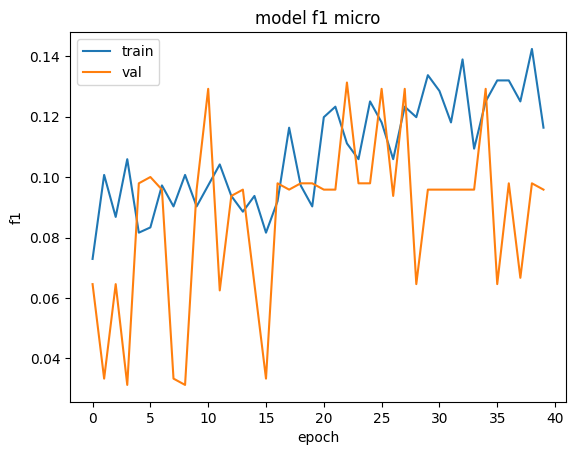

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.12      1.00      0.22         1
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.12      0.67      0.20         3

    accuracy                           0.10        31
   macro avg       0.02      0.12      0.03        31
weighted avg       0.02      0.10      0.03        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Скоры сильно хуже, чем у остальных моделей, в общем-то, она не учится, перебор параметров мне не помог :(

## с заморозкой на усреднённом hidden state

Изменим класс CLF, начнём подавать линейному слою на вход усреднённый вектор:

In [ ]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden.mean(dim=1) ))
        outputs=self.act(dense_outputs)

        return outputs

In [ ]:
model = AutoModel.from_pretrained(model_id)
for param in model.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000877222


In [ ]:
f1s = []
f1s_eval = []

for i in tqdm(range(40)):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

  0%|          | 0/40 [00:00<?, ?it/s]

0


  2%|▎         | 1/40 [00:25<16:51, 25.93s/it]

Eval -  0.1935483870967742
1


  5%|▌         | 2/40 [00:52<16:34, 26.16s/it]

Eval -  0.3225806451612903
2


  8%|▊         | 3/40 [01:17<15:46, 25.58s/it]

Eval -  0.45161290322580644
3


 10%|█         | 4/40 [01:41<15:09, 25.27s/it]

Eval -  0.5161290322580645
4


 12%|█▎        | 5/40 [02:07<14:47, 25.34s/it]

Eval -  0.4838709677419355
5


 15%|█▌        | 6/40 [02:32<14:23, 25.39s/it]

Eval -  0.5161290322580645
6


 18%|█▊        | 7/40 [02:58<13:55, 25.32s/it]

Eval -  0.5483870967741935
7


 20%|██        | 8/40 [03:23<13:29, 25.30s/it]

Eval -  0.5161290322580645
8


 22%|██▎       | 9/40 [03:48<13:05, 25.34s/it]

Eval -  0.5483870967741935
9


 25%|██▌       | 10/40 [04:14<12:40, 25.34s/it]

Eval -  0.6129032258064516
10


 28%|██▊       | 11/40 [04:39<12:13, 25.31s/it]

Eval -  0.6129032258064516
11


 30%|███       | 12/40 [05:04<11:49, 25.32s/it]

Eval -  0.6774193548387096
12


 32%|███▎      | 13/40 [05:30<11:24, 25.34s/it]

Eval -  0.6774193548387096
13


 35%|███▌      | 14/40 [05:55<10:59, 25.35s/it]

Eval -  0.6774193548387096
14


 38%|███▊      | 15/40 [06:20<10:33, 25.35s/it]

Eval -  0.6774193548387096
15


 40%|████      | 16/40 [06:46<10:08, 25.33s/it]

Eval -  0.6774193548387096
16


 42%|████▎     | 17/40 [07:11<09:42, 25.33s/it]

Eval -  0.6774193548387096
17


 45%|████▌     | 18/40 [07:36<09:17, 25.32s/it]

Eval -  0.6774193548387096
18


 48%|████▊     | 19/40 [08:01<08:51, 25.29s/it]

Eval -  0.6774193548387096
19


 50%|█████     | 20/40 [08:27<08:25, 25.26s/it]

Eval -  0.7096774193548387
20


 52%|█████▎    | 21/40 [08:52<08:00, 25.29s/it]

Eval -  0.6774193548387096
21


 55%|█████▌    | 22/40 [09:17<07:35, 25.30s/it]

Eval -  0.6774193548387096
22


 57%|█████▊    | 23/40 [09:43<07:10, 25.30s/it]

Eval -  0.6774193548387096
23


 60%|██████    | 24/40 [10:08<06:44, 25.30s/it]

Eval -  0.6774193548387096
24


 62%|██████▎   | 25/40 [10:33<06:19, 25.29s/it]

Eval -  0.7096774193548387
25


 65%|██████▌   | 26/40 [10:58<05:54, 25.30s/it]

Eval -  0.6774193548387096
26


 68%|██████▊   | 27/40 [11:24<05:29, 25.32s/it]

Eval -  0.7096774193548387
27


 70%|███████   | 28/40 [11:49<05:03, 25.32s/it]

Eval -  0.6451612903225806
28


 72%|███████▎  | 29/40 [12:15<04:38, 25.33s/it]

Eval -  0.7096774193548387
29


 75%|███████▌  | 30/40 [12:40<04:13, 25.35s/it]

Eval -  0.7096774193548387
30


 78%|███████▊  | 31/40 [13:05<03:48, 25.35s/it]

Eval -  0.7096774193548387
31


 80%|████████  | 32/40 [13:31<03:22, 25.34s/it]

Eval -  0.6774193548387096
32


 82%|████████▎ | 33/40 [13:56<02:57, 25.34s/it]

Eval -  0.7096774193548387
33


 85%|████████▌ | 34/40 [14:21<02:31, 25.32s/it]

Eval -  0.7096774193548387
34


 88%|████████▊ | 35/40 [14:46<02:06, 25.31s/it]

Eval -  0.7096774193548387
35


 90%|█████████ | 36/40 [15:12<01:41, 25.29s/it]

Eval -  0.7096774193548387
36


 92%|█████████▎| 37/40 [15:37<01:15, 25.32s/it]

Eval -  0.6774193548387096
37


 95%|█████████▌| 38/40 [16:02<00:50, 25.33s/it]

Eval -  0.7096774193548387
38


 98%|█████████▊| 39/40 [16:28<00:25, 25.35s/it]

Eval -  0.7096774193548387
39


100%|██████████| 40/40 [16:53<00:00, 25.34s/it]

Eval -  0.7096774193548387


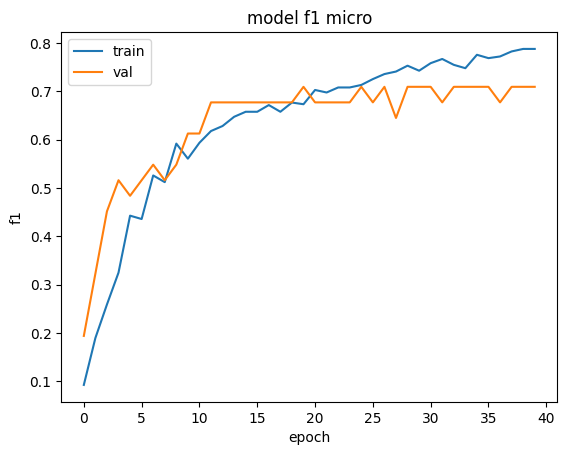

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [ ]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       0.80      0.80      0.80         5
           5       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.67      1.00      0.80         2
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         3
          16       0.67      0.67      0.67         3

    accuracy                           0.71        31
   macro avg       0.56      0.64      0.59        31
weighted avg       0.63      0.71      0.66        31



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Лучшие скоры среди всех моделей, хотя всё ещё есть классы с нулевыми метриками, видимо, для этой задачи классификации недостаточно CLS токена